# TIME SERIES

The predictability of an event or a quantity depends on several factors including:
- how well we understand the factors that contribute to it;
- how much data is available;
- whether the forecasts can affect the thing we are trying to forecast.

Quantitative forecasting can be applied when two conditions are satisfied:
- numerical information about the past is available;
- it is reasonable to assume that some aspects of the past patterns will continue into the future.




In [60]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import seaborn as sns
from pmdarima.arima import auto_arima
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import r2_score
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import statistics
import numpy
import math

In [7]:
df = pd.read_csv('Data/juan_1_step_per_min.csv')
train = df.step_sum
print(len(train))

6148


## 1. Preliminary analysis

### 1.1. Feature Correlation

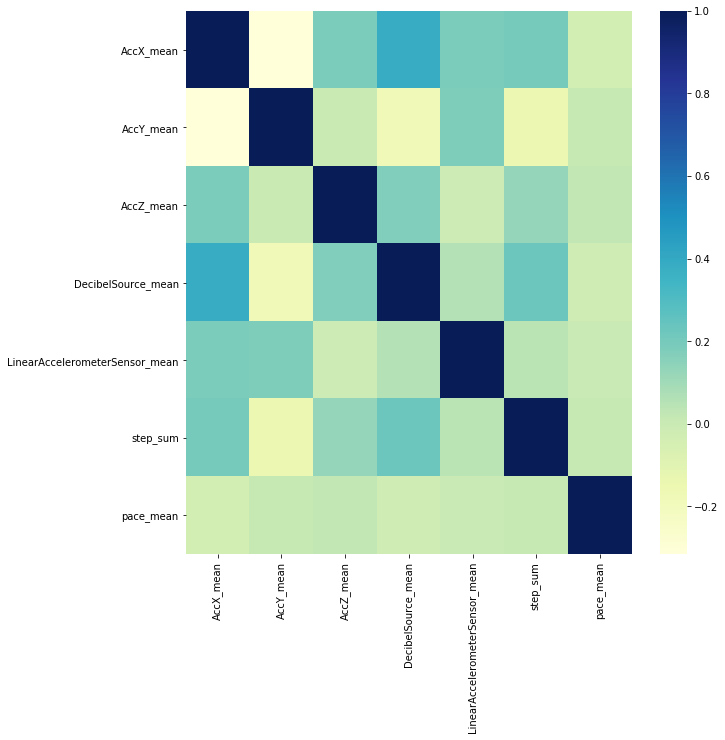

In [8]:
plt.figure(figsize=(10,10))
sns.heatmap(df[['AccX_mean','AccY_mean','AccZ_mean','DecibelSource_mean','LinearAccelerometerSensor_mean','step_sum', 'pace_mean']].corr(), cmap="YlGnBu")

### 1.2. Stationarity
The time series is stationary if the mean remains constant with time. In a linear regression model the data is prepared by a degree of differencing in order to make it stationary, i.e. to remove trend and seasonal structures that negatively affect the regression model and this can be done through differencing.

A trend exists when there is a long-term increase or decrease in the data. It does not have to be linear. The mean and standard deviation of the series should not be a function of time.



In [ ]:
plt.figure(figsize=(18,7))
plt.plot(train, color = 'green', label = 'Data')
plt.legend(loc = 'best')
plt.title('Data')
plt.show()

The Augmented Dickey-Fuller test is a type of statistical test called a unit root test.The intuition behind a unit root test is that it determines how strongly a time series is defined by a trend. It uses an autoregressive model and optimizes an information criterion across multiple different lag values.

The null hypothesis of the test is that the time series can be represented by a unit root, that it is not stationary (has some time-dependent structure). The alternate hypothesis (rejecting the null hypothesis) is that the time series is stationary.
- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary).

In [10]:
pvalue = adfuller(df.pace_mean)[1]
print(pvalue)

1.1547986075323238e-27


### 1.3. Autocorrelation 

Autocorrelation measures the linear relationship between lagged values of a time series and determines some important features. Let's mention two of them:

- **Cyclic** - A cycle occurs when the data exhibit rises and falls that are not of a fixed frequency. In general, the average length of cycles is longer than the length of a seasonal pattern, and the magnitudes of cycles tend to be more variable than the magnitudes of seasonal patterns.
- **Seasonal** - A seasonal pattern occurs when a time series is affected by seasonal factors such as the time of the year or the day of the week. Seasonality is always of a fixed and known frequency. 

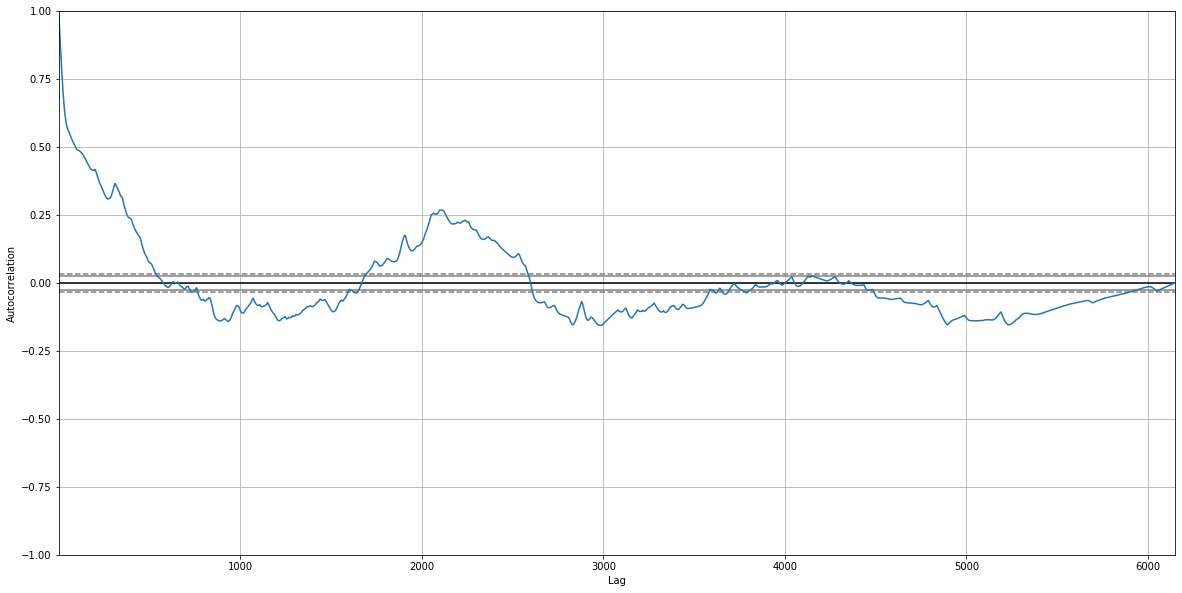

In [11]:
plt.figure(figsize=(20,10))
axes=autocorrelation_plot(train)

#### ACF

We know that the ACF describes the autocorrelation between an observation and another observation at a prior time step that includes direct and indirect dependence information.

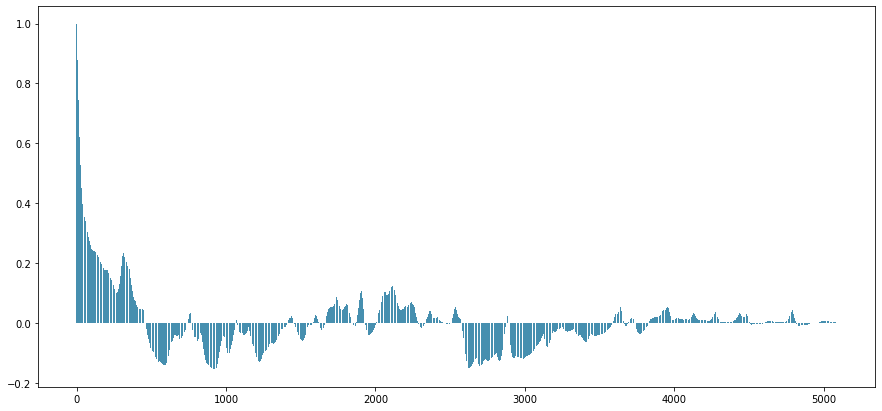

In [166]:
nlags = len(train)
#lags = acf(train,nlags=nlags)
plt.figure(figsize=(15,7))
plt.bar(range(nlags),lags[:nlags],color='#468faf')
axes.set_ylim([0,0.7])
plt.show()

#### PACF 
The PACF only describes the direct relationship between an observation and its lag. 

In [ ]:
plt.figure(figsize=(15,7))
p_lags = pacf(train,6000)
plt.bar(range(6000),p_lags[:6000],color='#468faf')

A series with strong seasonality will show clear peaks in the partial auto-correlation function as well as the auto-correlation function, whereas a cyclical series will only have the strong peaks in the auto-correlation function.

Since each running session can lasts for a variable amount of time, we cannot assume seasonality even though we expect a cyclic behaviour. To conclude, from the preliminary analysis we could observe that our time series is stationary and cyclic. 

## 2. Model

There's a variety of models that can be used on timeseries with a number of parameters that depend on the complexity and features of the model. 

- s = Number of lags per season
- p (ar) = Number of autoregressive terms.
- d (i) = Number of nonseasonal differences needed for stationarity.
- q (ma) = Number of lagged forecast errors in the prediction equation.

A value of 0 can be used for a parameter, which indicates to not use that element of the model. Given the features of out timeseries we set *i* and *s* to zero since there's no trend or seasonal behaviour, so we will be using an ARMA model.

In [254]:
# stefano 2021-06-22
# juan 2021-06-12-2021-06-17

In [24]:
y = df.reset_index()
y = y.drop_duplicates()
y = y[['step_sum']]
df.timestamp = [x[:10] for x in df.timestamp]
df.timestamp.unique()

array(['2021-04-15', '2021-04-16', '2021-04-21', '2021-04-22',
       '2021-04-24', '2021-04-27', '2021-04-30', '2021-05-02',
       '2021-05-04', '2021-05-07', '2021-05-09', '2021-05-12',
       '2021-05-18', '2021-05-20', '2021-05-24', '2021-05-27',
       '2021-06-04', '2021-06-12', '2021-06-17'], dtype=object)

In [25]:
last_session_start = df[df.timestamp=='2021-06-12'].index[0]
last_session_end = df[df.timestamp=='2021-06-17'].index[0]
train = y[:last_session_start]
test = y[last_session_start:last_session_end]

### 2.1. ARMA

The maximum likelihood estimation (MLE) is used for evaluating ARMA models.
ARMA also returns Akaike’s Information Criterion and the Bayesian Information Criterion. These information criteria tend not to be good guides to selecting the appropriate order of differencing (d) of a model, but only for selecting the values of p and q. This is because the differencing changes the data on which the likelihood is computed, making the AIC values between models with different orders of differencing not comparable.

#### Autoregressive model
In an autoregression model, we forecast the variable of interest using a linear combination of past values of the variable. The term autoregression indicates that it is a regression of the variable against itself.

Thus, an autoregressive model of order p can be written as: $y_t=c+\phi_1y_t−1+\phi_2y_t−2+...+\phi_py_t−p+\epsilon_t$

Consider a time series that was generated by an autoregression(AR) process with a lag of k. We would expect the ACF for the AR(k) time series to be strong to a lag of k and the inertia of that relationship would carry on to subsequent lag values, trailing off at some point as the effect was weakened. Since the PACF only describes the direct relationship between an observation and its lag, there should be no correlation for lag values beyond k.

#### Moving Avarage model

Rather than using past values of the forecast variable in a regression, a moving average model uses past forecast errors in a regression-like model. It can be written as:
$y_t=c+\epsilon_t+\theta_1\epsilon_t−1+\theta_2\epsilon_t−2+...+\theta_q\epsilon_t−q$, where εt is white noise. 

Consider a time series that was generated by a moving average (MA) process with a lag of k. The moving average process is an autoregression model of the time series of residual errors from prior predictions. We would expect the ACF for the MA(k) process to show a strong correlation with recent values up to the lag of k, then a sharp decline to low or no correlation. For the PACF, we would expect the plot to show a strong relationship to the lag and a trailing off of correlation from the lag onwards.


#### Order definition

Considering what just said, we could sey our AR and MA parameters by looking at the ACF and PACF, however this is just an indication and, expecially when the behaviour of the data is not really clear, tuning of the q and r parameters may be necessary to select the order. For this reason we will use the *AutoArima* function which allows to set an interval of values for p and q and it automatically returns the best model based on its AIC.



The best parameters selected by the minimization of AIC are:
    
- AR = 2
- MA = 1

In [56]:
# more tuning to be done
model = auto_arima(train,start_p=2,d=0,start_q=1,seasonal=False)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5091
Model:               SARIMAX(2, 0, 1)   Log Likelihood              -16361.228
Date:                Sat, 10 Jul 2021   AIC                          32732.455
Time:                        20:16:16   BIC                          32765.131
Sample:                             0   HQIC                         32743.897
                               - 5091                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5432      1.359      0.400      0.689      -2.120       3.207
ar.L1          1.8303      0.406      4.505      0.000       1.034       2.627
ar.L2         -0.8340      0.397     -2.100      0.036      -1.612      -0.056
ma.L1         -0.8336      0.420     -1.984      0.047      -1.657      -0.010
sigma2        36.2474      0.187    194.164      0.000      35.882      36.613
===================================================================================
Ljung-Box (Q):                        3.63   Jarque-Bera (JB):          32144023.39
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                           -18.90
Prob(H) (two-sided):                  0.00   Kurtosis:                       390.43
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Basically our model is described by the following equation:

$\hat{Y}= c + \phi_1y_{t−1}+\phi_2y_{t−2} + \theta_1\epsilon_{t−1}$

#### Adding exogenous variables

Here we use the parameteres returned by AutoArima and pass them to the ARMA model together with the exogenous variable that is more stongly correlated with our feature of interest, which is *delta altitude*.

In [66]:
model_end = ARIMA(endog=train,exog=df['delta_altitude_mean'][:train.shape[0]], order=[2,0,1])
model_end_fit = model_end.fit()
model_end_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:               step_sum   No. Observations:                 5091
Model:                     ARMA(2, 1)   Log Likelihood              -16325.197
Method:                       css-mle   S.D. of innovations              5.974
Date:                Sat, 10 Jul 2021   AIC                          32662.393
Time:                        20:27:30   BIC                          32701.604
Sample:                             0   HQIC                         32676.124
                                                                              
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 150.8491      4.028     37.454      0.000     142.955     158.743
delta_altitude_mean  -221.8709     25.224     -8.796      0.000    -271.308    -172.434
ar.L1.step_sum         -0.0150      0.072     -0.209      0.834      -0.156       0.126
ar.L2.step_sum          0.9737      0.070     13.849      0.000       0.836       1.111
ma.L1.step_sum          0.9946      0.070     14.276      0.000       0.858       1.131
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.0057           +0.0000j            1.0057            0.5000
AR.2            1.0212           +0.0000j            1.0212            0.0000
MA.1           -1.0054           +0.0000j            1.0054            0.5000
-----------------------------------------------------------------------------
"""

We can already observed that the AIC is already lower than the one previously obtained

### 2.2. Residuals on training set

Residuals are useful in checking whether a model has adequately captured the information in the data. A good forecasting method will yield residuals with the following properties:

- The residuals are uncorrelated. If there are correlations between residuals, then there is information left in the residuals which should be used in computing forecasts.
- The residuals have zero mean. If the residuals have a mean other than zero, then the forecasts are biased.


#### Predicions on endog

In [57]:
prediction_train = pd.DataFrame(model.predict(n_periods=train.shape[0]),index=train.index)
prediction_train.columns=['predicted_pace']
print(math.sqrt((sum(train.step_sum.dropna()-prediction_train.predicted_pace.dropna())**2)/len(train)))

21.007525612968657


#### Predicions on endog + exog

In [163]:
residuals = pd.DataFrame(model_end_fit.resid)
print(math.sqrt(sum(residuals)**2/len(train)))

0.0


### 2.3. Forecasting

We want to forecast a single running session at a time so we sill determine the training and te teast set based on the index at which we find a certain timestamp.

#### Point forecasts

Point forecasts can be calculated using the following three steps.
- Expand the ARIMA equation so that yt is on the left hand side and all other terms are on the right. Rewrite the equation by replacing t with T+h
- On the right hand side of the equation, replace future observations with their forecasts, future errors with zero, and past errors with the corresponding residuals.

#### Prediction with endog

In [101]:
prediction = pd.DataFrame(model.predict(n_periods=test.shape[0]),index=test.index)
prediction.columns=['predicted_pace']

#### Prediction with endog + exog

In [110]:
fitted, x, ci = model_end_fit.forecast(len(test), exog=np.array(df.delta_altitude_mean[last_session_start:last_session_end]))

### 2.4. Scoring results

#### R2

In [106]:
print('Endog only r2:    ',r2_score(test,prediction['predicted_pace']))
print('Endog + Exog r2:   ',r2_score(test,fitted))

Endog only:     -0.37762757025330607
Endog + Exog:    -0.3025222925271833


#### MAPE

In [107]:
print('Endog only mape:   ',np.mean(np.abs(prediction['predicted_pace'] - test.step_sum)/np.abs(test.step_sum)))
print('Endog + Exog mape:   ',np.mean(np.abs(fitted - test.step_sum)/np.abs(test.step_sum)))

Endog only mape:    0.08306293082430051
Endog + Exog mape:    0.07857477573281249


#### RMSE 

In [132]:
print('Endog only RMSE:   ',math.sqrt((sum(test.step_sum-prediction.predicted_pace)**2)/len(test)))
print('Endog + Exog RMSE:   ',math.sqrt((sum(test.step_sum-fitted.tolist())**2)/len(test)))

Endog only RMSE:    18.897920106033826
Endog + Exog RMSE:    11.732723175546688


#### Plots

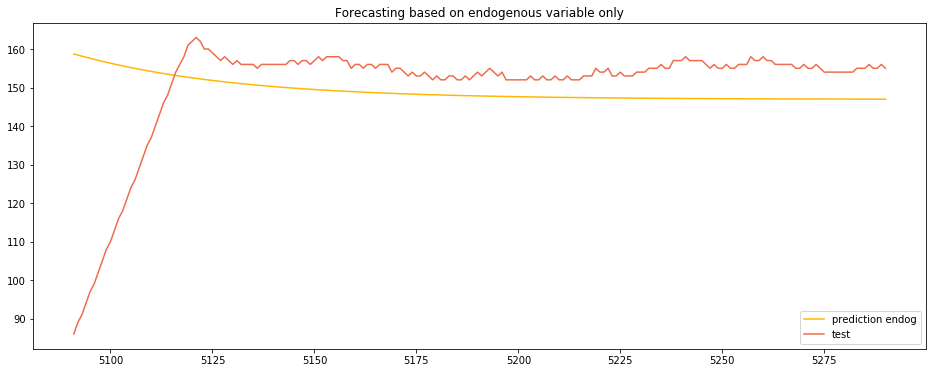

In [162]:
plt.figure(figsize=(16,6))
plt.plot(prediction.predicted_pace, label='prediction endog',color='#ffb703')
plt.plot(test,label='test',color='#ee6c4d')
plt.title("Forecasting based on endogenous variable only")
plt.legend(loc='lower right')
plt.show()

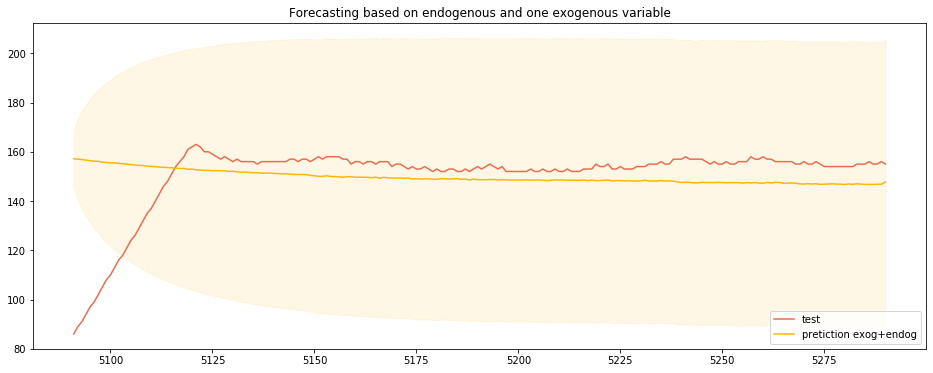

In [160]:
ci_lower = [x[0] for x in ci]
ci_upper = [x[1] for x in ci]
plt.figure(figsize=(16,6))
plt.plot(test,label='test',color='#ee6c4d')
plt.plot(test.index,fitted,label='pretiction exog+endog',color='#ffb703')
plt.fill_between(test.index, 
                 ci_lower, 
                 ci_upper, 
                 color='#ffb703', alpha=.1)
plt.title("Forecasting based on endogenous and one exogenous variable")
plt.legend(loc='lower right')

plt.show()